In [142]:
# utils
def BinarySearch(x, arr):
    mid = len(arr) // 2
    low = 0
    high = len(arr) - 1
    
    while arr[mid] != x and low <= high:
        if x > arr[mid]:
            low = mid + 1
        else:
            high = mid - 1
        mid = (low + high) // 2
    
    return mid


In [143]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import log, exp, sin, cos, sqrt

In [144]:
# Рассчёт значения из прошлого шагом плотной выдачи
def phi(x, X, Y, K, b, h, x0, past):
    if x < x0:
        return past(x)
    if x in X:
        return Y[X.index(x)]

    i_xm = BinarySearch(x, X)
    
    theta = (x - X[i_xm]) / h

    if(i_xm > len(K) - 1):
        return past(x)
    
    return Y[i_xm] + h * sum([K[i_xm][i] * b[i](theta) for i in range(len(b))])


In [145]:
# шаг явного метода
def stepExplicit(method, problem, X, Y, h, K):
    x = X[-1]
    y = Y[-1]
    z = problem.Z(X, Y, K, method.B, h, problem.x0, problem.past) if problem.Z else None

    # K_i = f(x_0 + h * c_i, y_0 + h * sum( K_j * A_ij ) ) i < j < N
    _K = []
    for i in range(method.N):
        dy = h * sum([_K[j] * method.A[i][j] for j in range(len(_K))])
        _K.append( problem.f(x + method.c[i] * h, y + dy, z) )
        
    return x + h, y + h * sum([_K[i] * method.B[i](1) for i in range(method.N)]), _K

# шаг неявного метода
def stepImplicit(method, problem, X, Y, h, K):
    x = X[-1]
    y = Y[-1]
    z = problem.Z(X, Y, K, method.B, h, problem.x0, problem.past) if problem.Z else None

    Zk = [problem.f(x, y, z)] * method.N
    J = problem.fprime(x, y, z)
    N = [
        [
            (1 if i == j else 0) - h * method.A[i][j] * J
            for j in range(method.N)
        ]
        for i in range(method.N)
        # [1 - h * method.A[0][0] * J, - h * method.A[0][1] * J],
        # [ - h * method.A[1][0] * J, 1 - h * method.A[1][1] * J]
    ]
    for _ in range(1):
        Fzk = [
            problem.f(x + method.c[i], y + Zk[i], z)
            for i in range(method.N)
        ]
        nb = [
            -Zk[i] + h * sum([
                method.A[i][j] * Fzk[j]
                for j in range(method.N)
            ])
            for i in range(method.N)
        ]
        Zk = np.linalg.solve(N, nb)

    return x + h, y + h * sum([Zk[i] * method.B[i](1) for i in range(method.N)]), Zk

In [146]:
class Method:
    def __init__(self, A, B, c, implict=False):
        self.A = A
        self.B = B
        self.c = c
        self.N = len(c)
        self.implicit = implict
        self.step = stepImplicit if implict else stepExplicit

In [147]:
class Problem:
    def __init__(self, x0, x1, y0, f, trueSol, fprime=None, past=None, Z=None):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.f = f
        self.trueSol = trueSol
        self.fprime = fprime
        self.past = past
        self.Z = Z

In [148]:
def getSolution(method, problem, h):
    x, y, k = problem.x0, problem.y0, []
    X = [x]
    Y = [y]
    K = k
    while X[-1] != problem.x1:
        if X[-1] + h > problem.x1:
            x, y, k = method.step(method, problem, X, Y, problem.x1 - X[-1], K)
        else:
            x, y, k = method.step(method, problem, X, Y, h, K)
        X.append(x)
        Y.append(y)
        K.append(k)
        
    return X, Y

In [149]:
def getGraph(method, problem, h):
    x, y = getSolution(method, problem, h)

    fig, ax = plt.subplots()
    trueSolDelay = [problem.trueSol(x) for x in x]

    ax.plot(x, y, 'r:')
    ax.plot(x, trueSolDelay, 'g')
    ax.grid(True)

    print(f'Err = {abs(y[-1] - trueSolDelay[-1])}')

In [150]:
def getGraph2Pow(method, problem, h, p=3):
    N = []
    H = []
    for k in range(1, 10):
        h = 1 / (2 ** k)
        H.append(np.log10(h))
        x, y = getSolution(method, problem, h)
        trueY = [problem.trueSol(x) for x in x]
        N.append(np.log10( abs(trueY[-1] - y[-1]) ))

    y = N[0]+p*(H-H[0])

    fig, ax = plt.subplots()
    ax.set_title(f'Log10: p = {p}')
    ax.plot(H, N, color='b', linestyle='--')
    # ax.plot([-4, -1], [-6, 0], 'r')
    ax.plot(H, y, 'r')
    ax.grid(True)

In [151]:
# Функция приближения значения из прошлого
def Z(X, Y, K, B, h, x0, past):
    def z(x):
        return phi(x, X, Y, K, B, h, x0, past)
    
    return z

In [152]:
# Задача 1
def solution1(x):
    if x <= 0:
        return 1
    if x <= 1:
        return 1 - x
    if x <= 2:
        return 1 - x + (x - 1)**2 / 2
    if x <= 3:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6
    if x <= 4:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6 + (x - 3)**4 / 24
    if x <= 5:
        return 1 - x + (x - 1)**2 / 2 - (x - 2)**3 / 6 + (x - 3)**4 / 24 - (x - 4)**5 / 120
    
H_1 = 0.3 

def f1(x, y, z):
    return -z(x - 1)

def fprime1(x, y, z):
    return 0

def past1(x):
    return 1

problem1 = Problem(x0 = 0, x1 = 5, y0 = 1, f = f1, trueSol = solution1, fprime = fprime1, past = past1, Z = Z)


In [153]:
# Задача 2
xi1, xi2, xi3 = 1, 2, 5.0294372515248
def solution2(x):
    if x < xi1:
        return 1
    if x < xi2:
        return sqrt(x)
    else:
        return x/4 + 1/2 + (1 - 1 / sqrt(2)) * sqrt(x) 

H_2 = 0.3 

def f2(x, y, z):
    return z(y - sqrt(2) + 1) / (2 * sqrt(x))

def fprime2(x, y, z):
    return 0

def past2(x):
    return 1

problem2 = Problem(x0 = 1, x1 = 3, y0 = 1, f = f2, trueSol = solution2, fprime = fprime2, past = past2, Z = Z)

In [154]:
# Получение 4-x четырёхшагового метода CREK
A = [
    [0,       0,        0,       0],
    [12/23,   0,        0,       0],
    [-68/375, 368/375,  0,       0],
    [31/144,  529/1152, 125/384, 0]
]

B = [
    lambda theta: 41/72 * theta**3 - 65/48 * theta**2 + theta,
    lambda theta: -529/576 * theta**3 + 529/384 * theta**2,
    lambda theta: -125/192 * theta**3 + 125/128 * theta**2,
    lambda theta: theta**3 - theta**2
]

C = [0, 12/23, 4/5, 1]

CREK_method = Method(A, B, C)

Err = 6.936867097248611e-05


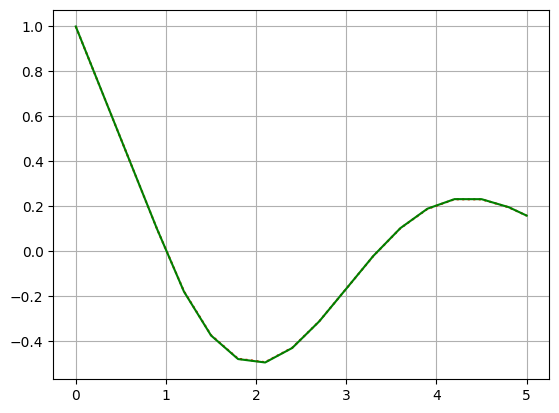

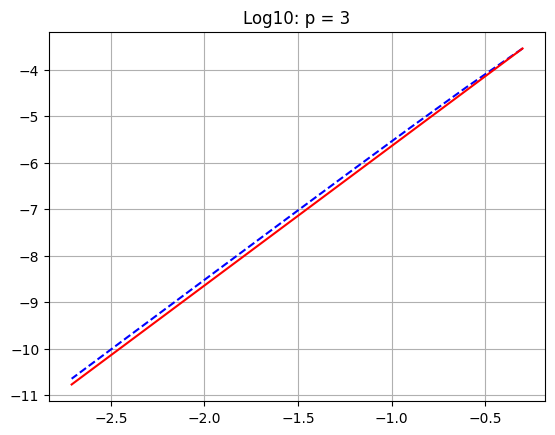

In [155]:
getGraph(CREK_method, problem1, H_1)
getGraph2Pow(CREK_method, problem1, H_1)

Err = 0.00010726106221503606


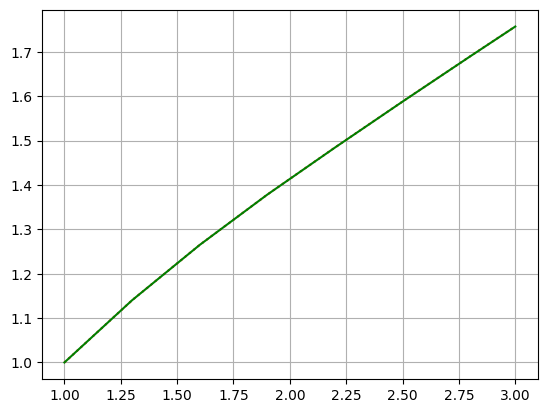

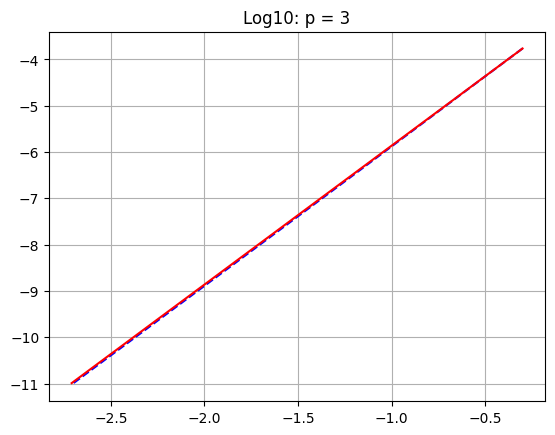

In [156]:
getGraph(CREK_method, problem2, H_2)
getGraph2Pow(CREK_method, problem2, H_2)

In [157]:
# Параметры метода Гаусса 2
A = [
        [1/4, (1 - 2/sqrt(3))/4],
        [(1 + 2/sqrt(3))/4, 1/4]
    ]

B = [
    lambda theta: (1 + sqrt(3)) * theta / 2 - sqrt(3) * theta * theta / 2,
    lambda theta: (1 - sqrt(3)) * theta / 2 + sqrt(3) * theta * theta / 2,
]

C = [(1 - 1/sqrt(3))/2, (1 + 1/sqrt(3))/2]

GAUSS_method = Method(A, B, C, implict=True)

Err = 12.235003441081972


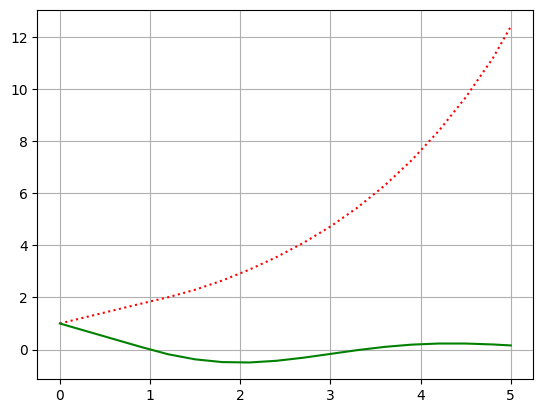

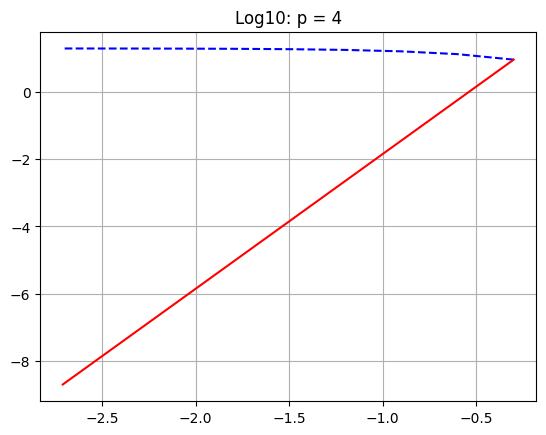

In [158]:
getGraph(GAUSS_method, problem1, H_1)
getGraph2Pow(GAUSS_method, problem1, H_1, p = 4)

In [159]:
def solution3(x):
    return 3 * sin(x) - 5 * cos(x)
    
def f3(x, y, z):
    return y + z(x - np.pi) + 3 * cos(x) + 5 * sin(x)

def fprime3(x, y, z):
    return 1

def past3(x):
    return 3 * sin(x) - 5 * cos(x)

H_3 = 0.3

problem3 = Problem(x0 = 0, x1 = 2*np.pi, y0 = solution3(0), f = f3, trueSol = solution3, fprime = fprime3, past = past3, Z = Z)


Err = 10.355974920051775


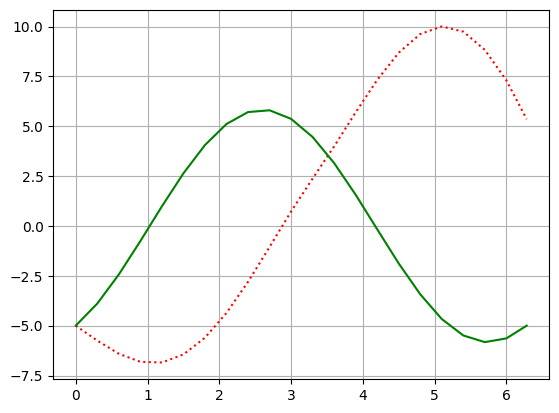

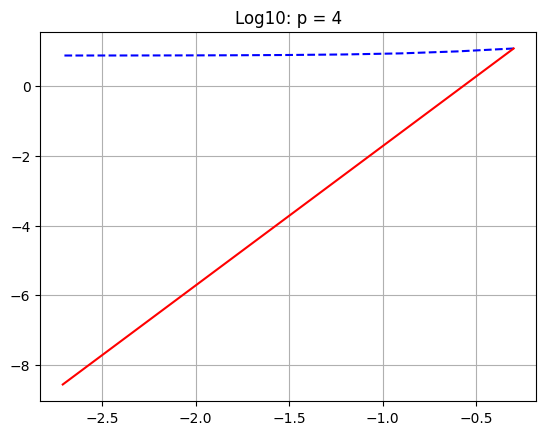

In [160]:
getGraph(GAUSS_method, problem3, H_3)
getGraph2Pow(GAUSS_method, problem3, H_3, p = 4)